
<img src="cat.jpg" width="240" height="240"/>

Written by: <span style="color:SteelBlue">Duy Huynh</span>

---

# Clustering
Clustering is the task of grouping objects into clusters, such that objects within the same cluster are as similar as possible. We basically split the complicated data into simpler chunks for analysis. Some use case examples include:

- Segmentation of household by income and family size
- Partition the general population of consumers by *market segments*
- Personality group

For Exploratory Data Analysis, *Clustering* is especially useful, as it helps to give insight into the basic characteristic of the data at hands, asking the question of underlying connectivity properties.

## K-means clustering
K-means is a centroid-based clustering technique. In layman term, 
- k (free parameter, have to be defined) stands for the number of groups you want to split the data by. 
- from each group, you find a centroid, such that the **squared distances** from the cluster are minimized

Compared to other clustering algorithm, k-means has the advantage of *interpretability*, as group features are directly comparable to the original features, it is easier to perform analysis on the result. It is important to be optimal with our algorithm; But, in a business point of view, being able to interpret and communicate our findings to others is also an invaluable objective. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [2]:
df = pd.read_csv("data/E-commerce.csv")

In [3]:
df.head(10)

ID  n_clicks  n_visits  amount_spent  amount_discount  \
0  2085       643       142    300.000000       228.432503   
1   742       527        95    743.832508        60.882831   
2   750       367        49    305.668886        72.961801   
3  1224       466        30    291.191193       101.903170   
4  2210       715       169    703.136878       506.416735   
5  1632       204        84    312.331152        59.930122   
6  2416       600       135   1008.169771       717.696496   
7   903       316       115    823.874562         6.360026   
8   111       224       115    800.000000        24.414520   
9  1581       363       132    322.490806        67.122764   

   days_since_registration  profile_information  
0                      132                  411  
1                       86                  184  
2                      334                  329  
3                      131                  148  
4                      114                  160  
5                      274                  295  
6                      165                   28  
7                      184                  146  
8                      324                    0  
9                      248                  101

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2500 non-null   int64  
 1   n_clicks                 2500 non-null   int64  
 2   n_visits                 2500 non-null   int64  
 3   amount_spent             2500 non-null   float64
 4   amount_discount          2500 non-null   float64
 5   days_since_registration  2500 non-null   int64  
 6   profile_information      2500 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 136.8 KB


---
# Data Explanation
This is a E-commerce dataset showing advertisment and page interaction from 2500 customers 

Features:
- ID: Unique identifier of a customer
- n_clicks: number of clicks on products
- n_visits: number of visit on the page
- amount_spent: amount of money spent on products
- amount_discount: amount paid after discount
- day_since_registration: account's current age
- profile_information: The completion of a customer profile, score from 0 to 100
---

We will first visualize the data and try to gain more insight into what we are working with.

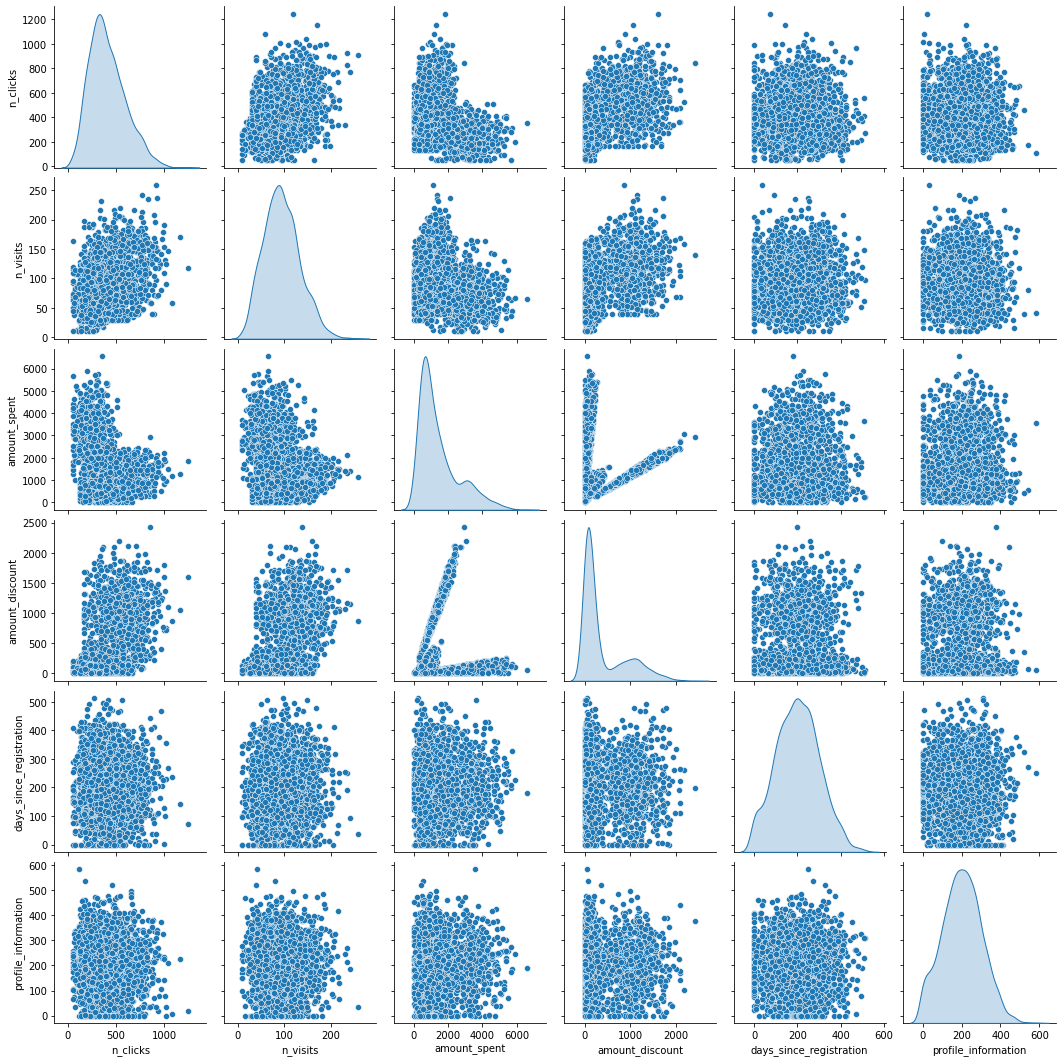

In [5]:
sns.pairplot(df.drop(columns=['ID'], axis=1), diag_kind='kde')

At first glance, we can see most attributes follow a normal distribution, except for "amount_spent" and "amount_discount". We will seperate them into a jointplot for analysis.

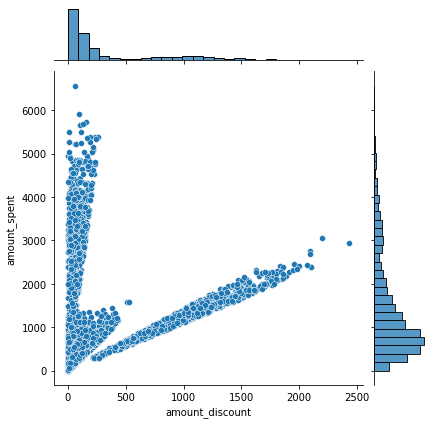

In [6]:
sns.jointplot(y=df['amount_spent'], x=df['amount_discount'])

Looking at the visualization, we can conclude that:
- **amount_spent** has a bell shape with long right tail, which does make sense if sale amount of luxury, expensive products is lower
- Due to the nature of the attributes, **amount_discount** has a mode of 0, and see steep decline at value above 300
- **amount_discount** positively correlate with **amount_spent**, but this correlation is by designed as **amount_discount** is calculated directly using **amount_spent**.

## Implementing Clustering
To make things simple, we first implement clustering based only 2 axis: "n_clicks", and "amount_spent", since the clusters from these 2 features are pretty obvious.

<AxesSubplot:xlabel='amount_spent', ylabel='n_visits'>

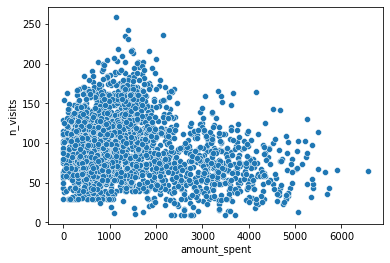

In [7]:
c_df = df.loc[:,["amount_spent","n_visits"]]
sns.scatterplot(x=df['amount_spent'],y=df['n_visits'])

If we use just our human eyes, we can clearly see 2 seperate groups derived from the scatter plot. One with high spending amount but low clicks, and high amount of clicks but low spending amount

# Feature scaling
K-means clustering method functions by minimizing intra-variance between each group, which requires the calculation of distance between each pair of observations. Specifically in this note, we will use **Euclidean distance**.
$d\left( x,y\right)   = \sqrt {\sum _{i=1}^{n}  \left( y_{i}-x_{i}\right)^2 }$


Using this formula, every columns should be normalized, so that the value difference between 2 columns will not skew the result. (amount_spent's values are generally a lot higher than n_visits). Normalization will be performed using min-max scaler.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
scaler.fit(c_df)
X = pd.DataFrame(scaler.transform(c_df))
X.columns = c_df.columns
X


amount_spent  n_visits
0         0.045680  0.530120
1         0.113261  0.341365
2         0.046543  0.156627
3         0.044339  0.080321
4         0.107065  0.638554
...            ...       ...
2495      0.506841  0.622490
2496      0.302396  0.064257
2497      0.142662  0.301205
2498      0.061654  0.204819
2499      0.218302  0.602410

[2500 rows x 2 columns]

# Choosing k
As mentioned above, k is a free parameter and have to be chosen, which now raise the question of "What's the optimal number for k?"

We want the amount of cluster to be big enough to minimize the variance within each group, but not too large that it creates artificial boundaries within a group.

## Method
There exist many methods to figure out k:
- Elbow method
- Silhouette method
- Gap statistics

In this note we will use Elbow to determine k. It is easier to explain the method with visualization

<AxesSubplot:xlabel='Clusters', ylabel='Sum of Squared Distances'>

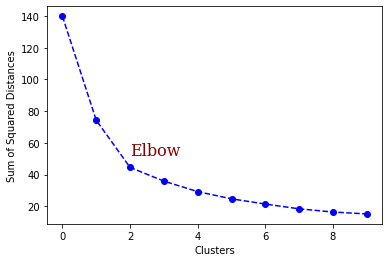

In [9]:
def DrawElbow(data):
    intra_variance=[]
    for i in range(1,11):
        km = KMeans(n_clusters=i,
                   max_iter=300)
        km.fit(data)
        intra_variance.append(km.inertia_)
    intra_variance=pd.Series(intra_variance)
    return intra_variance

wcss = DrawElbow(X)
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.ylabel('Sum of Squared Distances')
plt.xlabel('Clusters') 
plt.text(2,wcss[2]+5,"Elbow", ha='left',va = "bottom",fontdict=font)
wcss.plot(linestyle='--', marker='o', color='b', label='line with marker')

If you can guess, we iterate through a range of k, and determine at what value of k do we stop seeing a huge drop for intra-variance, aka the "elbow".

As shown in the chart, sum of Squared Distance (or intra-variance) see a steep drops, up until **3 clusters**. So, k=3 is our "elbow", and also the optimal amount of cluster. So now we implement k-means on the data with k=3.

<AxesSubplot:xlabel='amount_spent', ylabel='n_visits'>

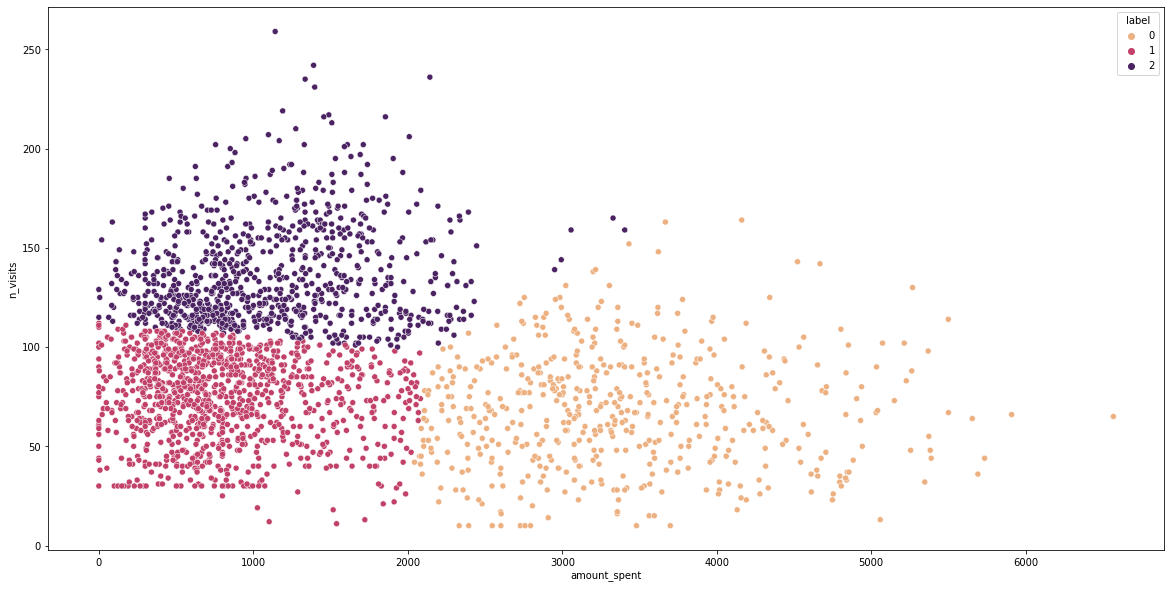

In [10]:
km = KMeans(n_clusters=3,
               max_iter=300)
km.fit(X)
c_df['label'] = km.labels_
plt.figure(figsize=(20,10))
sns.scatterplot(x=c_df['amount_spent'], y=c_df["n_visits"], hue=c_df['label'],palette="flare")

---
Unlike what we suspected, the data is classfied into 3 clusters 
- High visit but low spending
- Low visit low spending
- Low visit and high spending 


With this in mind, we can perform analysis *seperately* on each group, and make action accordingly. Here we only clustered 2 features so we will hold off analysis for now and expand the process to all features in our dataset first.

---

Scaling all features in the data

In [11]:
df = df.drop(columns=['ID'], axis=1)
scaler.fit(df)
df_scaled = pd.DataFrame(scaler.transform(df))
df_scaled.columns = df.columns
df_scaled

n_clicks  n_visits  amount_spent  amount_discount  \
0     0.495819  0.530120      0.045680         0.094067   
1     0.398829  0.341365      0.113261         0.025071   
2     0.265050  0.156627      0.046543         0.030045   
3     0.347826  0.080321      0.044339         0.041963   
4     0.556020  0.638554      0.107065         0.208539   
...        ...       ...           ...              ...   
2495  0.151338  0.622490      0.506841         0.061074   
2496  0.159699  0.064257      0.302396         0.002112   
2497  0.427258  0.301205      0.142662         0.060384   
2498  0.248328  0.204819      0.061654         0.049120   
2499  0.646321  0.602410      0.218302         0.468710   

      days_since_registration  profile_information  
0                    0.256809             0.702564  
1                    0.167315             0.314530  
2                    0.649805             0.562393  
3                    0.254864             0.252991  
4                    0.221790             0.273504  
...                       ...                  ...  
2495                 0.305447             0.536752  
2496                 0.428016             0.352137  
2497                 0.186770             0.338462  
2498                 0.377432             0.200000  
2499                 0.527237             0.396581  

[2500 rows x 6 columns]

Using elbow method to determine k

<AxesSubplot:xlabel='Clusters', ylabel='Sum of Squared Distances'>

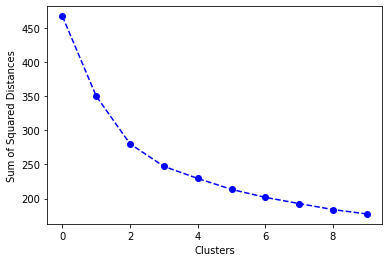

In [12]:
wcss = DrawElbow(df_scaled)
plt.ylabel('Sum of Squared Distances')
plt.xlabel('Clusters') 
wcss.plot(linestyle='--', marker='o', color='b', label='line with marker')

At 3 clusters, the intra-variance starts decreasing in a somewhat linear fashion, so we choose 3 as our optimal k

In [13]:
km = KMeans(n_clusters=3,
               max_iter=300)
km.fit(df_scaled)
df['label'] = km.labels_+1
df_scaled['label'] = km.labels_+1

# Interpretation for Business Action
With 3 group fully distinguised, we can now perform both horizontal comparisons between each group, and vertical analysis seperately for one group at a time. This reduces the complexity of our data, and emphasizes meaningful underlying structures. An obvious business use case example would be "If we have an advertisement program, which group of user should we target?"

First we have to visualize the lables. Because we have 6 features, it is a lot harder to fully visualize the data on a 2d or 3d planes. The best we can do is parallel coordinate, which is a common visualization for high-dimentional data.


In [14]:
df.groupby('label').mean()

n_clicks    n_visits  amount_spent  amount_discount  \
label                                                          
1      386.411858   89.947036    646.966945       145.221189   
2      586.822727  126.122727   1404.592274      1123.615193   
3      253.193043   68.113043   3247.448308        79.966540   

       days_since_registration  profile_information  
label                                                
1                   201.683794           196.807115  
2                   202.342424           198.090909  
3                   197.840000           213.739130

Here we see that "days_since_registration" and "profile_information" are both very similar throughout the groups. So we should drop them for the sake of simplicity.

In [15]:
df_dropped = df.drop(columns=['days_since_registration', "profile_information"],axis=1)

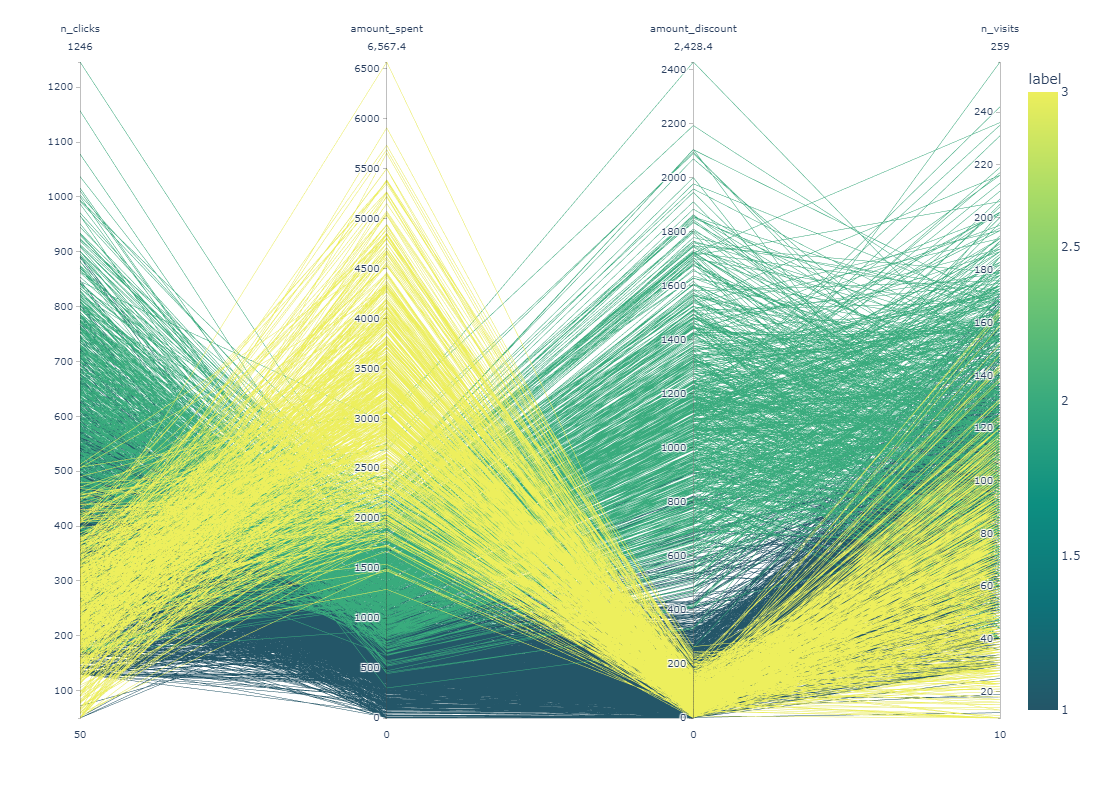

In [21]:
fig = px.parallel_coordinates(df_dropped, color="label", dimensions=['n_clicks','amount_spent', 'amount_discount' ,'n_visits'],
                              color_continuous_scale=px.colors.sequential.Aggrnyl, width=1100, height=800)
fig.write_image("fig1.png")
Image(filename='fig1.png') 

At first look the Parallel Coordinates plot might seem a bit convoluted, but it can still give us good information and is a good place to start for the analysis. Looking at the plot, we can see:
- Group 3 has a much higher amount_spent than the other 2 groups, but its *product clicks*, *site visits*, and *amount_discount* are all substaintially lower.
    - The group does not interact much with the websites, and most of their products are heavily discounted. They might be deals hunter, buying products only with available gift cards
- Group 2 on average has the highest amount of interaction with the websites. Their spending is lower than group 1, but the amount of discount they get is also a lot lower. 
    - Advertising will be more effective on group 3 with the inherently high interaction frequency
- Group 1 has a good amount of interaction, but their spending is a lot lower. We can choose this group for further analysis



[Text(0.5, 1.0, 'interaction Group 1')]

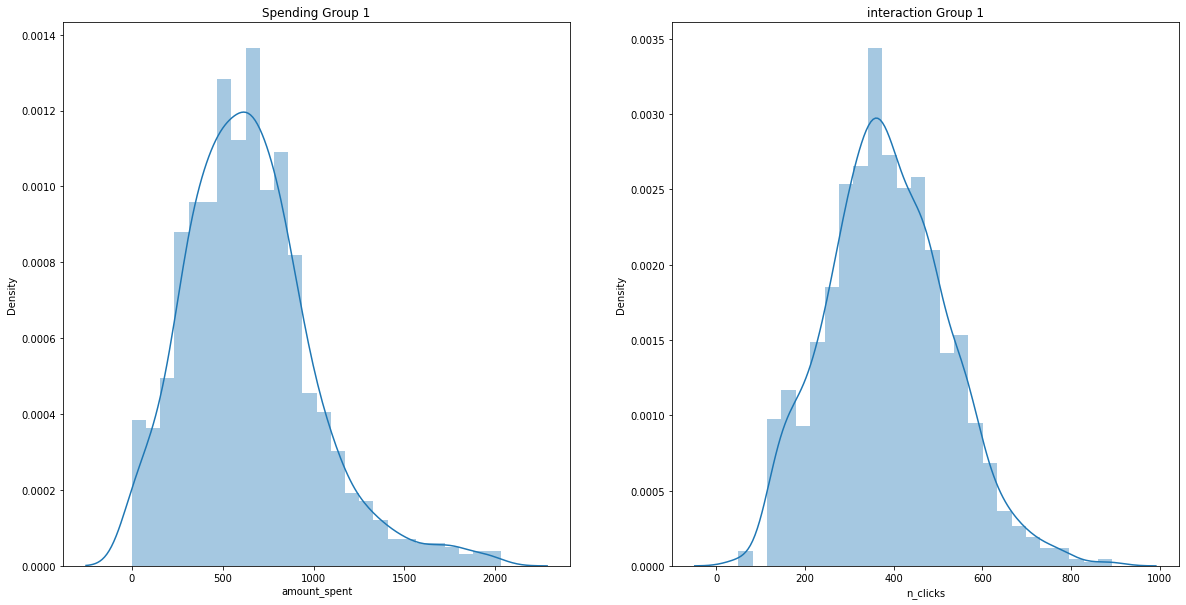

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
sns.distplot(df[df['label']==1].amount_spent, ax=axes[0]).set(title='Spending Group 1')
sns.distplot(df[df['label']==1].n_clicks, ax=axes[1]).set(title='interaction Group 1')

As an example of univariate analysis, we will draw distribution plot of spending and interaction for group 3. We can see clearly that both variance roughly follow a normal distribution and don't have noticable outliers (maybe except for the small right-tail). The average spending for the group is about 550, which is only 1/3 compared to group 2. A good amount of user in this group has 0 spending, so we can concludes lots of them are just window-browsing. 

From these conclusions, maybe a markerter with more domain knowledge will have a suitable strategy to aim at these type of customers.

# Conclusions
In this note we discussed the definition of clustering, and expand on k-means as a clustering method. We implemented k-mean clustering by first scaling our features, choosing the optimal k through the "elbow method", and then interpreted our results with additional analysis. 

## Things not discuss in this note
There were some important elements outside the scope of note that were not implicitly mentioned, including:
- The data assumption for k-means clustering
- The drawback of k-means clustering
- Different calculation for Clustering Distance Measures

## Resources
[*K-means Cluster Analysis*](https://uc-r.github.io/kmeans_clustering#distance)

[*Clustering With More Than Two Features*](https://towardsdatascience.com/clustering-with-more-than-two-features-try-this-to-explain-your-findings-b053007d680a)

[*Clustering With K-Means*](https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means/tutorial)

[*How to understand the drawbacks of K-means*](https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means)

[*Parallel Coordinates Plot in Python*](https://plotly.com/python/parallel-coordinates-plot/#parallel-coordinates-plot-with-plotly-express)